In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm

import scipy
from scipy.special import expit as sigmoid
import jax.numpy as jnp
import jax
import numpy as np
import numpy.typing as npt
Float = np.float64

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml
dev = qml.device("lightning.gpu", wires=18)

[cuda(id=0)]


In [2]:
TESTING = False

In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
# remember to delete cache when rewriting function
import diskcache as dc
cache = dc.Cache(
    ROOT + '/.cache/pennylane_sim/',
    size_limit = 2 ** 32, # 4GB
)

In [5]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *

In [6]:
# if either is the 0 vector, then norm is undefined. unlikely to occur
@qml.qjit(seed=0)
@qml.qnode(dev)
def swap_circuit(data1:npt.NDArray[Float], data2:npt.NDArray[Float], norm:bool=True) -> npt.NDArray[Float]:
    l1, l2 = len(data1), len(data2)
    assert l1 == l2

    # data embedding
    qml.AngleEmbedding(data1, wires=range(l1))
    qml.AngleEmbedding(data2, wires=range(l1, l1+l2))
    # qml.IQPEmbedding(data1, wires=range(l1))
    # qml.IQPEmbedding(data2, wires=range(l1, l1+l2))
    # # QFT is inv DFT; inv QFT is DFT
    # qml.adjoint(
    qml.QFT(wires = range(l1))
    # )
    # qml.adjoint(
    qml.QFT(wires = range(l1, l1 + l2))
    # )

    # Swap test
    for i in range(l1):
        qml.CNOT(wires = [i, l1 + i])
    qml.Barrier()
    for i in range(l1):
        qml.H(i)

    return qml.probs(wires = range(l1 + l2))

In [7]:
def rescale(x):
    #return sigmoid(x / np.linalg.norm(x, ord=1)) * np.pi/2
    return x / np.linalg.norm(x, ord=1) * np.pi/2

In [8]:
#fast enough to compute w/o caching



# don't cache while debugging
# @cache.memoize()
def get_fidelity_memo(data1:list[int], data2:list[int]) -> tuple[Float,Float]:
    probs = swap_circuit(data1, data2)
    _, fidelity = swap_expectation(probs, len(data1))
    mean = np.mean(np.array(probs)) # circuit exp value?
    return mean, fidelity

def get_fidelity(data1:list[int], data2:list[int]) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1)
    # normalize data
    data1 = rescale(data1) # sigmoid(data1 / np.linalg.norm(data1, ord=1)) * np.pi/2
    data2 = rescale(data2) # sigmoid(data2 / np.linalg.norm(data2, ord=1)) * np.pi/2
    # print(data1 == data2)
    return get_fidelity_memo(data1, data2)

In [9]:
# should get 1
a = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
b = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
c = np.array([3]*9, dtype=Float)
#normalization will make these equal to each other

In [10]:
rescale(c)

array([0.17453293, 0.17453293, 0.17453293, 0.17453293, 0.17453293,
       0.17453293, 0.17453293, 0.17453293, 0.17453293])

In [11]:
print(a.dtype)

float64


In [12]:
print('Drawing')
print(qml.draw(swap_circuit)(rescale(a), rescale(c)))

Drawing
 0: ─╭AngleEmbedding(M0)─╭QFT─╭●──────────────────────────||──H─┤ ╭Probs
 1: ─├AngleEmbedding(M0)─├QFT─│──╭●───────────────────────||──H─┤ ├Probs
 2: ─├AngleEmbedding(M0)─├QFT─│──│──╭●────────────────────||──H─┤ ├Probs
 3: ─├AngleEmbedding(M0)─├QFT─│──│──│──╭●─────────────────||──H─┤ ├Probs
 4: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──╭●──────────────||──H─┤ ├Probs
 5: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──╭●───────────||──H─┤ ├Probs
 6: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──│──╭●────────||──H─┤ ├Probs
 7: ─├AngleEmbedding(M0)─├QFT─│──│──│──│──│──│──│──╭●─────||──H─┤ ├Probs
 8: ─╰AngleEmbedding(M0)─╰QFT─│──│──│──│──│──│──│──│──╭●──||──H─┤ ├Probs
 9: ─╭AngleEmbedding(M0)─╭QFT─╰X─│──│──│──│──│──│──│──│───||────┤ ├Probs
10: ─├AngleEmbedding(M0)─├QFT────╰X─│──│──│──│──│──│──│───||────┤ ├Probs
11: ─├AngleEmbedding(M0)─├QFT───────╰X─│──│──│──│──│──│───||────┤ ├Probs
12: ─├AngleEmbedding(M0)─├QFT──────────╰X─│──│──│──│──│───||────┤ ├Probs
13: ─├AngleEmbedding(M0)─├QFT─────────────╰

In [13]:
mean_swap, fidelity = get_fidelity(a, b)
mean_swap, fidelity

(np.float64(3.8146972656249822e-06), Array(1., dtype=float64))

# run simulated results on significant neurons of smallest recording

In [14]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

In [15]:
try:
    0/0
    quantum_fidelity = pd.read_csv(ROOT + '/data/quantum_fidelity.csv')

except:
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'mean_value', 'fidelity'])

    # A x B
    pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
        mean_value, fidelity = get_fidelity(a_i, b_i)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, mean_value, fidelity]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, mean_value, fidelity]

    # A x A
    # for sanity checking
    for a in tqdm(sig_neurons):
        a_i = tuning_curves.loc[a]
        mean_value, fidelity = get_fidelity(a_i, a_i)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, mean_value, fidelity]

    quantum_fidelity.to_csv(ROOT + '/data/quantum_fidelity.csv')


  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [16]:
quantum_fidelity_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['fidelity']

In [17]:
quantum_mean_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['mean_value']

In [18]:
quantum_fidelity_matrix[23][32]

0.9834686166548982

In [19]:
quantum_fidelity_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
A,,,,,,,,,,,,,,,,,,,,,
23,1.0,0.983469,0.998301,0.995586,0.998037,0.998615,0.998931,0.999071,0.99877,0.99751,...,0.997999,0.996915,0.995379,0.995421,0.991937,0.994209,0.999024,0.997477,0.998165,0.997142
32,0.983469,1.0,0.986347,0.989628,0.991082,0.989021,0.988169,0.986838,0.986038,0.990345,...,0.991712,0.991853,0.990953,0.990105,0.974791,0.978682,0.987461,0.990263,0.988338,0.990895
35,0.998301,0.986347,1.0,0.99637,0.997878,0.998989,0.999435,0.998599,0.99812,0.999062,...,0.998495,0.998278,0.996094,0.996666,0.989106,0.991312,0.999459,0.997465,0.998744,0.998322
36,0.995586,0.989628,0.99637,1.0,0.99657,0.995759,0.997655,0.995427,0.994087,0.996964,...,0.997096,0.996959,0.995593,0.995051,0.981408,0.989681,0.996415,0.996282,0.995873,0.99792
37,0.998037,0.991082,0.997878,0.99657,1.0,0.999186,0.999226,0.99851,0.99873,0.99908,...,0.999228,0.999288,0.996825,0.997382,0.991679,0.992373,0.99878,0.99882,0.998778,0.999204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.994209,0.978682,0.991312,0.989681,0.992373,0.994445,0.992345,0.99547,0.994065,0.989326,...,0.992295,0.988601,0.989411,0.984668,0.986978,1.0,0.9927,0.993541,0.988557,0.989965
425,0.999024,0.987461,0.999459,0.996415,0.99878,0.999567,0.99962,0.999204,0.999359,0.999201,...,0.998841,0.99883,0.997662,0.997065,0.991647,0.9927,1.0,0.997498,0.998848,0.998562
426,0.997477,0.990263,0.997465,0.996282,0.99882,0.998361,0.998382,0.99775,0.996825,0.99799,...,0.999283,0.997383,0.993508,0.995209,0.987662,0.993541,0.997498,1.0,0.99787,0.998489


In [20]:
quantum_mean_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
A,,,,,,,,,,,,,,,,,,,,,
23,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
32,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
35,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
36,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
37,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
425,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
426,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


In [21]:
np.float64(2)/2**18

np.float64(7.62939453125e-06)

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

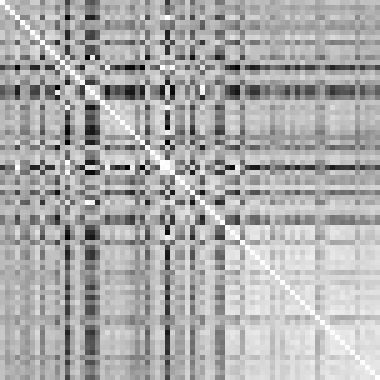

In [23]:
q_mean_corr = pd.DataFrame(quantum_mean_matrix).corr().to_numpy()
Image.fromarray(
    (q_mean_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

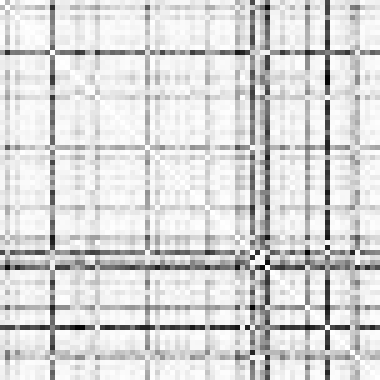

In [24]:
q_fidelity_corr = pd.DataFrame(quantum_fidelity_matrix).corr().to_numpy()
Image.fromarray(
    (q_fidelity_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

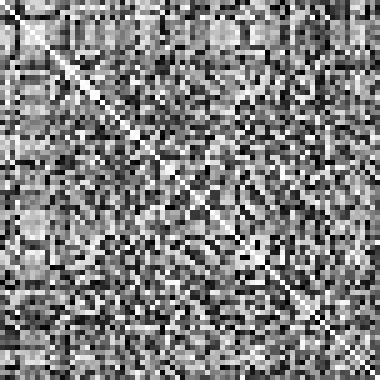

In [25]:
corrs = tuning_curves.T.corr().to_numpy()
Image.fromarray(
    (corrs * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

In [26]:
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

classical_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean'])

 # A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in pairs:
    a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    # print(dist)
    classical_distance.loc[len(classical_distance)] = [a, b, dist]
    classical_distance.loc[len(classical_distance)] = [b, a, dist]

# # A x A
# # for sanity checking
for a in sig_neurons:
    a_i = tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    classical_distance.loc[len(classical_distance)] = [a, a, dist]

In [27]:
classical_distance['euclidean'][0]

np.float64(57.489713065330626)

In [28]:
classical_distance_matrix = classical_distance.pivot_table(index = 'A', columns = 'B')['euclidean']

In [29]:
classical_distance_matrix

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,57.489713,15.673022,32.390285,17.576971,12.735483,13.170797,15.677175,20.828368,18.432809,...,15.311713,32.906094,25.817023,22.904627,336.287309,65.497791,11.533044,24.211957,18.424718,22.689595
32.0,57.489713,0.000000,52.771415,45.990628,43.804962,49.948916,53.508839,51.272857,52.756258,45.874278,...,45.945187,41.249058,43.507421,49.629841,334.668219,80.574786,51.126581,44.575297,48.862794,43.555141
35.0,15.673022,52.771415,0.000000,28.440559,17.716748,13.395683,15.574955,15.496736,20.206583,11.595409,...,15.977783,25.781608,23.608061,22.647838,334.466514,66.496907,8.835821,22.395968,14.465426,17.073113
36.0,32.390285,45.990628,28.440559,0.000000,27.189350,32.965551,32.683349,29.776658,33.516520,26.892119,...,30.267146,25.852305,29.264449,36.228114,332.619011,62.836156,28.939034,27.007108,28.905031,21.192116
37.0,17.576971,43.804962,17.716748,27.189350,0.000000,13.640350,17.909171,15.565263,16.759792,11.809627,...,13.939224,20.453064,21.348063,21.837044,330.222239,63.594681,13.638144,15.925541,13.971873,11.791310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,65.497791,80.574786,66.496907,62.836156,63.594681,66.432092,73.810065,55.252345,55.002961,70.057234,...,69.993030,63.793526,67.841486,81.304534,296.560043,0.000000,65.370300,56.711613,69.003652,65.896650
425.0,11.533044,51.126581,8.835821,28.939034,13.638144,9.017099,13.179892,13.043485,15.884670,10.537249,...,13.394874,25.088487,18.430763,20.454258,333.458332,65.370300,0.000000,22.819565,14.340762,16.419648
426.0,24.211957,44.575297,22.395968,27.007108,15.925541,22.629235,27.060906,19.935004,23.849603,20.674766,...,20.106911,24.971405,32.891454,32.513397,328.410373,56.711613,22.819565,0.000000,19.888270,16.764802


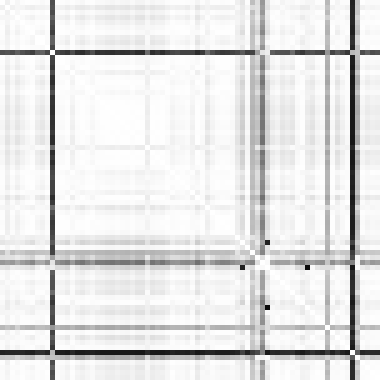

In [30]:
euclidean_corr = classical_distance_matrix.corr().to_numpy()
Image.fromarray(
    (euclidean_corr * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

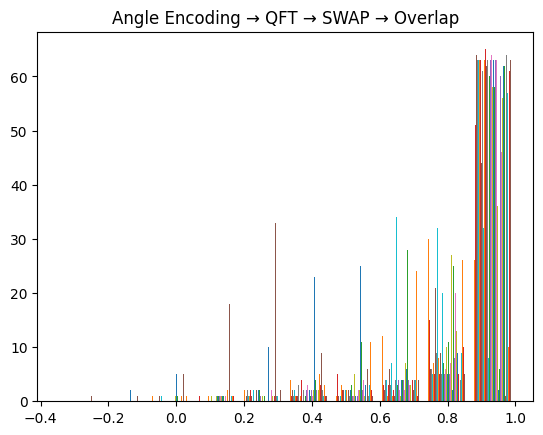

In [31]:
_ = plt.hist(q_fidelity_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap')

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x7f4f7e384350>],
 'cmeans': <matplotlib.collections.LineCollection at 0x7f4df0fccd50>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f4df0fc0290>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f4df0e38790>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f4df129b590>}

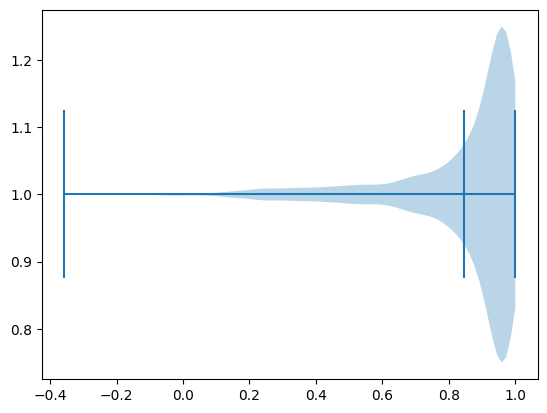

In [32]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

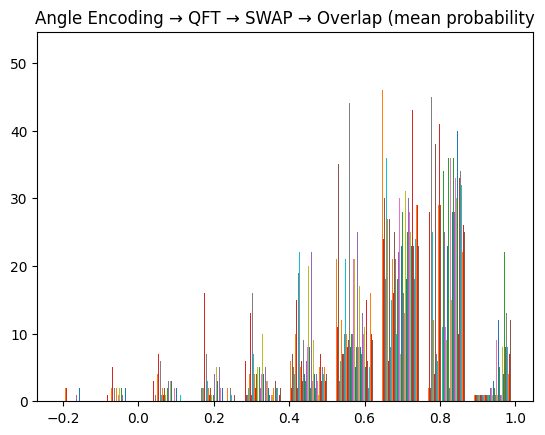

In [33]:
_ = plt.hist(q_mean_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap (mean probability')

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x7f4df0a83210>],
 'cmeans': <matplotlib.collections.LineCollection at 0x7f4df08e6bd0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f4df08d5890>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f4df070bcd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f4df0885410>}

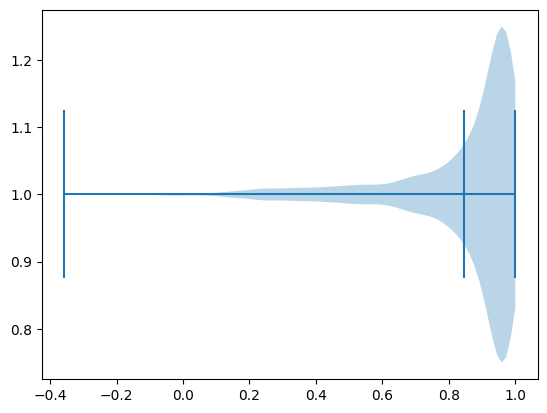

In [34]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

similar distributions? with harmonic-ish stuff in research
- [superoscillations](https://www.semanticscholar.org/paper/Super-oscillation-by-higher-order-radially-beams-Matsunaga-Kozawa/0784f24ec848c9e2fa002c7806de992859977ee1)
- [higher-order gaussian](https://www.researchgate.net/figure/The-normalized-intensity-distribution-of-hollow-higher-order-cosh-Gaussian-beams-at-the_fig1_347963556)

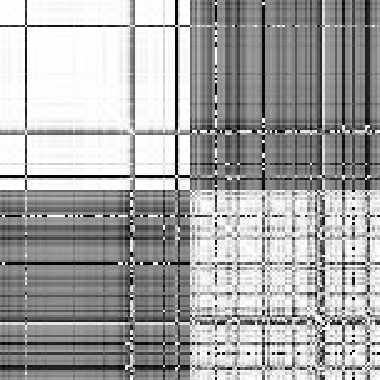

In [35]:
corr_of_corrs = np.corrcoef(euclidean_corr, q_fidelity_corr)
Image.fromarray(
    (corr_of_corrs * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

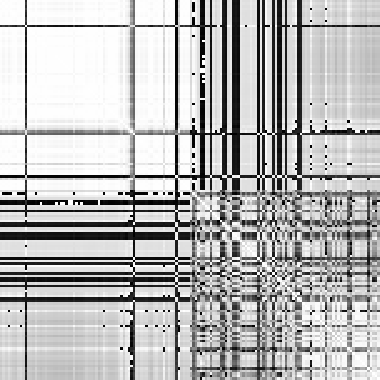

In [36]:
corr_of_corrs = np.corrcoef(euclidean_corr, q_mean_corr)
Image.fromarray(
    (corr_of_corrs * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

In [37]:
# ideally the kendalltau should be low (close to 0) with a significant pvalue
# in this case we have a high correlation so this is a problem
scipy.stats.kendalltau(euclidean_corr, q_fidelity_corr)

SignificanceResult(statistic=np.float64(0.468221322537112), pvalue=np.float64(0.0))

In [38]:
# ideally the kendalltau should be low (close to 0) with a significant pvalue
# in the case we have a low correlation so this is an improvement
scipy.stats.kendalltau(euclidean_corr, q_mean_corr)

SignificanceResult(statistic=np.float64(-0.03475711917914186), pvalue=np.float64(7.502295189299727e-05))

In [39]:
# but what about the mean of the signal curve?

In [40]:
(a_i+b_i) / sum(a_i+b_i)

0    0.110016
1    0.077126
2    0.109956
3    0.144895
4    0.108821
5    0.100214
6    0.107508
7    0.119228
8    0.122236
Name: 435, dtype: float64

In [41]:
# create a new probability distribution and take its mean
def mean_signal(a,b):
    return np.mean((a+b) / np.sum(a+b))
mean_sum_prob = pd.DataFrame(columns = ['A', 'B', 'mean'])

 # A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in pairs:
    a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
    dist = mean_signal(a_i, b_i)
    # print(dist)
    mean_sum_prob.loc[len(mean_sum_prob)] = [a, b, dist]
    mean_sum_prob.loc[len(mean_sum_prob)] = [b, a, dist]

# # A x A
# # for sanity checking
for a in sig_neurons:
    a_i = tuning_curves.loc[a]
    dist = mean_signal(a_i, a_i)
    mean_sum_prob.loc[len(mean_sum_prob)] = [a, a, dist]

mean_sum_prob_matrix = mean_sum_prob.pivot_table(index = 'A', columns = 'B')['mean']

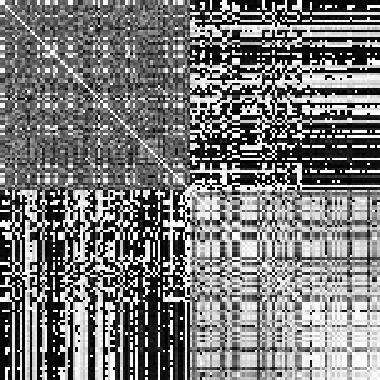

In [42]:
corr_of_corrs = np.corrcoef(mean_sum_prob_matrix.corr(), q_mean_corr)
Image.fromarray(
    (corr_of_corrs * 255).astype(np.uint8),
    mode = 'L'
).resize((len(sig_neurons) * 5, len(sig_neurons) * 5), Image.NEAREST).show()

In [43]:
scipy.stats.kendalltau(mean_sum_prob_matrix, q_mean_corr)

SignificanceResult(statistic=np.float64(0.019139808990827803), pvalue=np.float64(0.07080868231262254))

# summary

- quantum state fidelity is highly correlated with euclidean distance
- using sigmoid may not help
- removing / adding Hs to the canonical swap produces uncorrelated value
- Taking the mean of the probability of the bitstrings can also produce an uncorrelated value
- kendalltau can show correlation

# TODO

- run on QPU (no mitigation)
- run on QPU (with Mitiq)
- end to end analysis